In [1]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer
NTDBGPT2_tokenizer = AutoTokenizer.from_pretrained('dracoglacius/NTDB-GPT2')

from utils import *
from mdf import *

/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview

We have the intuition that given a distribution with center of the hyper-elliposid $c$ and the shape of the ellipsoid defined by $\Sigma$, $c$ and $\sigma$ should not deviate from the empirical mean ($\hat{c}$) and the covariance estimations ($\hat{\Sigma}$) taken from the training data. 

To obtain these estimates we need to:

1. Feed the NTDB model with the training data (length $n$) and from the last token get the features of each layer ($n$ x 13 x 768)
1. Calculate the sample mean ($\hat{c}$) and the covariance estimate ($\hat{\Sigma}$), while also getting the estimated pseudo-inverse (called `.precision_` in sklearn)

To obtain the OOD estimation we need to:

1. Calculate the Mahalanobis Distance Feature (MDF) using the generated data (should be a vector equal to the number of layers)
1. Calculate the Anomaly Score
  1. This is a one-class SVM with a linear kernel with MDF as features

# Configurations

In [2]:
PRINT_SEQUENCES = 20
TRN_FRAC = 0.9

## Load Data

In [3]:
trn_seq = np.load("../data/25k_train_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")
gen_seq = np.load("../data/25k_gen_seqs_3_22_E8859_E8120_E9660_E9654_E9240.npy")

e8120_trn_seq = filter_token_length([x for x in trn_seq if 'E812.0' in x], NTDBGPT2_tokenizer) # 5000 items
e8859_trn_seq = filter_token_length([x for x in trn_seq if 'E885.9' in x], NTDBGPT2_tokenizer) # 5000 items
e9660_trn_seq = filter_token_length([x for x in trn_seq if 'E966.0' in x], NTDBGPT2_tokenizer) # 5000 items
e9654_trn_seq = filter_token_length([x for x in trn_seq if 'E965.4' in x], NTDBGPT2_tokenizer) # 5000 items
e9240_trn_seq = filter_token_length([x for x in trn_seq if 'E924.0' in x], NTDBGPT2_tokenizer) # 5000 items

e8120_gen_seq = filter_token_length([x for x in gen_seq if 'E812.0' in x], NTDBGPT2_tokenizer) # 5000 items
e8859_gen_seq = filter_token_length([x for x in gen_seq if 'E885.9' in x], NTDBGPT2_tokenizer) # 5000 items
e9660_gen_seq = filter_token_length([x for x in gen_seq if 'E966.0' in x], NTDBGPT2_tokenizer) # 5000 items
e9654_gen_seq = filter_token_length([x for x in gen_seq if 'E965.4' in x], NTDBGPT2_tokenizer) # 5000 items
e9240_gen_seq = filter_token_length([x for x in gen_seq if 'E924.0' in x], NTDBGPT2_tokenizer) # 5000 items

# E812.0

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 678.54it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([438, 13])
torch.Size([438, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 47.19it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.64it/s]


 AUROC  DTACC  AUIN   AUOUT 
 63.10  62.79  59.36  70.02
best hyper linear-1e-15
saving data for plotting
-------------------------------


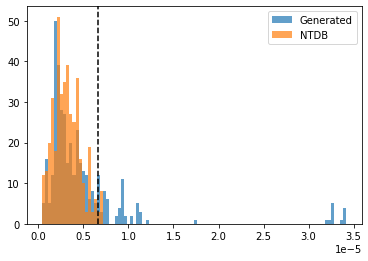

Normal: 322 Anomaly: 116


In [4]:
e8120_report, e8120_border, e8120_model, e8120_trn, e8120_tst, e8120_ood = oc_svm_detector('e8120', e8120_trn_seq, e8120_gen_seq, TRN_FRAC, PRINT_SEQUENCES, pcodes=True)

In [5]:
for s in e8120_trn_seq[:5]:
    print_seq_dsc(s, pcodes=True)
    print()

========= START =========
========== DXS ==========
8600:Traum pneumothorax-close:Traumatic pneumothorax without mention of open wound into thorax
80702:Fracture two ribs-closed:Closed fracture of two ribs

========= START =========
========== DXS ==========
9190:Abrasion NEC:Abrasion or friction burn of other, multiple, and unspecified sites, without mention of infection
8798:Open wound site NOS:Open wound(s) (multiple) of unspecified site(s), without mention of complication
8509:Concussion NOS:Concussion, unspecified
82525:Fx metatarsal-closed:Closed fracture of metatarsal bone(s)

========= START =========
========== DXS ==========
87340:Open wound of face NOS:Open wound of face, unspecified site, without mention of complication
8509:Concussion NOS:Concussion, unspecified

========= START =========
========== DXS ==========
87342:Open wound of forehead:Open wound of forehead, without mention of complication

========= START =========
========== DXS ==========
92411:Contusion of knee

In [6]:
n = e8120_report[e8120_report['score']<e8120_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
E885.9:Accidental fall from other slipping tripping or stumbling
========== DXS ==========
82021:Intertrochanteric fx-cl:Closed fracture of intertrochanteric section of neck of femur

========= START =========
E812.0:Other motor vehicle traffic accident involving collision with motor vehicle injuring driver of motor vehicle other than motorcycle
========== DXS ==========
8600:Traum pneumothorax-close:Traumatic pneumothorax without mention of open wound into thorax
8220:Fracture patella-closed:Closed fracture of patella
8054:Fx lumbar vertebra-close:Closed fracture of lumbar vertebra without mention of spinal cord injury

========= START =========
E812.0:Other motor vehicle traffic accident involving collision with motor vehicle injuring driver of motor vehicle other than motorcycle
========== DXS ==========
87342:Open wound of forehead:Open wound of forehead, without mention of complication
85223:Subdural hemorr-mod coma:Subdural hemorrhage following injury wi

In [7]:
w = e8120_report[e8120_report['score']>e8120_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
E812.0:Other motor vehicle traffic accident involving collision with motor vehicle injuring driver of motor vehicle other than motorcycle
========== DXS ==========
920:Contusion of face, scalp, and neck except eye(s):None
9110:Abrasion trunk:Abrasion or friction burn of trunk, without mention of infection
9100:Abrasion head:Abrasion or friction burn of face, neck, and scalp except eye, without mention of infection
87341:Open wound of cheek:Open wound of cheek, without mention of complication
87340:Open wound of face NOS:Open wound of face, unspecified site, without mention of complication
8730:Open wound of scalp:Open wound of scalp, without mention of complication
86121:Lung contusion-closed:Contusion of lung without mention of open wound into thorax
85300:Traumatic brain hem NEC:Other and unspecified intracranial hemorrhage following injury without mention of open intracranial wound, unspecified state of consciousness
8470:Sprain of neck:Sprain of neck
82525

# E885.9

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 626.79it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([446, 13])
torch.Size([446, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 48.53it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.59it/s]


 AUROC  DTACC  AUIN   AUOUT 
 61.11  64.69  55.31  69.86
best hyper linear-1e-15
saving data for plotting
-------------------------------


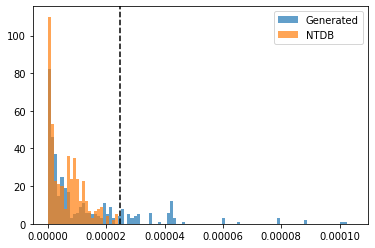

Normal: 334 Anomaly: 112


In [8]:
e8859_report, e8859_border, e8859_model, e8859_trn, e8859_tst, e8859_ood = oc_svm_detector('e8859', e8859_trn_seq, e8859_gen_seq, TRN_FRAC, PRINT_SEQUENCES, pcodes=True)

In [9]:
for s in e8859_trn_seq[:5]:
    print_seq_dsc(s, pcodes=True)
    print()

========= START =========
========== DXS ==========
85300:Traumatic brain hem NEC:Other and unspecified intracranial hemorrhage following injury without mention of open intracranial wound, unspecified state of consciousness
8730:Open wound of scalp:Open wound of scalp, without mention of complication

========= START =========
========== DXS ==========
82021:Intertrochanteric fx-cl:Closed fracture of intertrochanteric section of neck of femur
81201:Fx surg nck humerus-clos:Closed fracture of surgical neck of humerus

========= START =========
========== DXS ==========
83101:Ant disloc humerus-close:Closed anterior dislocation of humerus
81209:Fx upper humerus NEC-cl:Other closed fracture of upper end of humerus

========= START =========
========== DXS ==========
8208:Fx neck of femur NOS-cl:Closed fracture of unspecified part of neck of femur

========= START =========
========== DXS ==========
8370:Dislocation ankle-closed:Closed dislocation of ankle
82381:Fx fibula NOS-closed:Closed

In [10]:
n = e8859_report[e8859_report['score']<e8859_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
E885.9:Accidental fall from other slipping tripping or stumbling
========== DXS ==========
87342:Open wound of forehead:Open wound of forehead, without mention of complication
82021:Intertrochanteric fx-cl:Closed fracture of intertrochanteric section of neck of femur

========= START =========
E885.9:Accidental fall from other slipping tripping or stumbling
========== DXS ==========
83813:Disl tarsometatarsal-opn:Open dislocation of tarsometatarsal (joint)
8371:Dislocation ankle-open:Open dislocation of ankle
82535:Fx metatarsal-open:Open fracture of metatarsal bone(s)

========= START =========
E885.9:Accidental fall from other slipping tripping or stumbling
========== DXS ==========
923:Contusion of upper limb:None
920:Contusion of face, scalp, and neck except eye(s):None
80025:Cl skul vlt fx-deep coma:Closed fracture of vault of skull with subarachnoid, subdural, and extradural hemorrhage, with prolonged [more than 24 hours] loss of consciousness, without r

In [11]:
w = e8859_report[e8859_report['score']>e8859_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
E885.9:Accidental fall from other slipping tripping or stumbling
========== DXS ==========
80230:Mandible fx NOS-open:Open fracture of mandible, unspecified site
8020:Nasal bone fx-closed:Closed fracture of nasal bones

========= START =========
E885.9:Accidental fall from other slipping tripping or stumbling
========== DXS ==========
85222:Subdural hem-brief coma:Subdural hemorrhage following injury without mention of open intracranial wound, with brief [less than one hour] loss of consciousness
85202:Subarach hem-brief coma:Subarachnoid hemorrhage following injury without mention of open intracranial wound, with brief [less than one hour] loss of consciousness
85302:Brain hem NEC-brief coma:Other and unspecified intracranial hemorrhage following injury without mention of open intracranial wound, with brief [less than one hour] loss of consciousness
80701:Fracture one rib-closed:Closed fracture of one rib
80507:Fx c7 vertebra-closed:Closed fracture of seventh

# E966.0

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 581.93it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([449, 13])
torch.Size([449, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 53.81it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.68it/s]


 AUROC  DTACC  AUIN   AUOUT 
 52.44  59.47  48.39  62.06
best hyper linear-0.5
saving data for plotting
-------------------------------


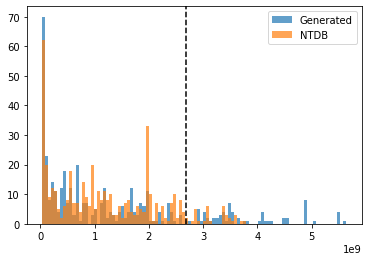

Normal: 336 Anomaly: 113


In [12]:
e9660_report, e9660_border, e9660_model, e9660_trn, e9660_tst, e9660_ood = oc_svm_detector('e9660', e9660_trn_seq, e9660_gen_seq, TRN_FRAC, PRINT_SEQUENCES, pcodes=True)

In [13]:
for s in e9660_trn_seq[:5]:
    print_seq_dsc(s, pcodes=True)
    print()

========= START =========
========== DXS ==========
8792:Opn wnd anterior abdomen:Open wound of abdominal wall, anterior, without mention of complication
8760:Open wound of back:Open wound of back, without mention of complication

========= START =========
========== DXS ==========
8910:Open wnd knee/leg/ankle:Open wound of knee, leg [except thigh], and ankle, without mention of complication
8900:Open wound of hip/thigh:Open wound of hip and thigh, without mention of complication
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8792:Opn wnd anterior abdomen:Open wound of abdominal wall, anterior, without mention of complication
8750:Open wound of chest:Open wound of chest (wall), without mention of complication
87342:Open wound of forehead:Open wound of forehead, without mention of complication
81602:Fx dist phalanx, hand-cl:Closed fracture of distal phalanx or phalanges of hand

========= START =========
========== DXS ==========
86112:Heart lacer

In [14]:
n = e9660_report[e9660_report['score']<e9660_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
8604:Traum pneumohemothor-cl:Traumatic pneumohemothorax without mention of open wound into thorax
80711:Fracture one rib-open:Open fracture of one rib

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8760:Open wound of back:Open wound of back, without mention of complication

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
8798:Open wound site NOS:Open wound(s) (multiple) of unspecified site(s), without mention of complication
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8750:Open wound of chest:Open wound of chest (wall), without mention of complication
8605:Traum pneumohemothor-opn:Traumatic pneumohemothorax with open wound into thorax

========= STAR

In [15]:
w = e9660_report[e9660_report['score']>e9660_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
8748:Open wound of neck NEC:Open wound of other and unspecified parts of neck, without mention of complication
875:Open wound of chest (wall):None

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8801:Open wound of shoulder and upper arm complicated:None
8605:Traum pneumohemothor-opn:Traumatic pneumohemothorax with open wound into thorax
8601:Traum pneumothorax-open:Traumatic pneumothorax with open wound into thorax

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
8794:Opn wnd lateral abdomen:Open wound of abdominal wall, lateral, without mention of complication

========= START =========
E966.0:Assault by cutting and piercing instrument
========== DXS ==========
8800:Open wound of shoulder and

# E965.4

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 579.90it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([447, 13])
torch.Size([447, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 55.70it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 11.00it/s]


 AUROC  DTACC  AUIN   AUOUT 
 60.60  62.86  52.67  68.61
best hyper linear-0.2
saving data for plotting
-------------------------------


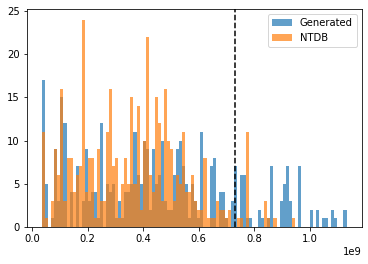

Normal: 334 Anomaly: 113


In [16]:
e9654_report, e9654_border, e9654_model, e9654_trn, e9654_tst, e9654_ood = oc_svm_detector('e9654', e9654_trn_seq, e9654_gen_seq, TRN_FRAC, PRINT_SEQUENCES, pcodes=True)

In [17]:
for s in e9654_trn_seq[:5]:
    print_seq_dsc(s, pcodes=True)
    print()

========= START =========
========== DXS ==========
8053:Fx dorsal vertebra-open:Open fracture of dorsal [thoracic] vertebra without mention of spinal cord injury
8760:Open wound of back:Open wound of back, without mention of complication
30560:Cocaine abuse-unspec:Cocaine abuse, unspecified
30570:Amphetamine abuse-unspec:Amphetamine or related acting sympathomimetic abuse, unspecified
3051:Tobacco use disorder:Tobacco use disorder

========= START =========
========== DXS ==========
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
8605:Traum pneumohemothor-opn:Traumatic pneumohemothorax with open wound into thorax
80711:Fracture one rib-open:Open fracture of one rib

========= START =========
========== DXS ==========
8900:Open wound of hip/thigh:Open wound of hip and thigh, without mention of complication
88101:Open wound of elbow:Open wound of elbow, without mention of complication
82532:Fx navicular, foot-open:Open fracture of navicular [scapho

In [18]:
n = e9654_report[e9654_report['score']<e9654_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
E965.4:Assault by firearms and explosives, Other and unspecified firearm
========== DXS ==========
9598:Injury mlt site/site NEC:Other specified sites, including multiple injury
80239:Mult fx mandible-open:Open fracture of mandible, multiple sites

========= START =========
E965.4:Assault by firearms and explosives, Other and unspecified firearm
========== DXS ==========
80040:Cl skl vlt fx/br inj NEC:Closed fracture of vault of skull with intracranial injury of other and unspecified nature, unspecified state of consciousness
8760:Open wound of back:Open wound of back, without mention of complication
82521:Fx astragalus-closed:Closed fracture of astragalus
95892:Trauma comp synd low ext:Traumatic compartment syndrome of lower extremity

========= START =========
E965.4:Assault by firearms and explosives, Other and unspecified firearm
========== DXS ==========
95892:Trauma comp synd low ext:Traumatic compartment syndrome of lower extremity
8901:Open wnd hip/thi

In [19]:
w = e9654_report[e9654_report['score']>e9654_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
E965.4:Assault by firearms and explosives, Other and unspecified firearm
========== DXS ==========
891:Open wound of knee leg (except thigh) and ankle:None

========= START =========
E965.4:Assault by firearms and explosives, Other and unspecified firearm
========== DXS ==========
8910:Open wnd knee/leg/ankle:Open wound of knee, leg [except thigh], and ankle, without mention of complication
88003:Open wound of upper arm:Open wound of upper arm, without mention of complication
81611:Fx mid/prx phal, hand-op:Open fracture of middle or proximal phalanx or phalanges of hand

========= START =========
E965.4:Assault by firearms and explosives, Other and unspecified firearm
========== DXS ==========
8792:Opn wnd anterior abdomen:Open wound of abdominal wall, anterior, without mention of complication
8750:Open wound of chest:Open wound of chest (wall), without mention of complication

========= START =========
E965.4:Assault by firearms and explosives, Other and unsp

# E924.0

100%|██████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 615.60it/s]
/home/paul/Stemmler/StemmlerProject/mdf.py:51: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(test_mdf)
/home/paul/Stemmler/StemmlerProject/mdf.py:52: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(ood_mdf)


torch.Size([449, 13])
torch.Size([449, 13])


 73%|██████████████████████████████████████████████▌                 | 8/11 [00:00<00:00, 55.78it/s]/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
/home/paul/anaconda3/envs/stemmler/lib/python3.8/site-packages/sklearn/svm/_classes.py:1661: RuntimeWarning: invalid value encountered in add
  return self.decision_function(X) + self.offset_
100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.84it/s]


 AUROC  DTACC  AUIN   AUOUT 
 55.36  62.36  48.89  66.08
best hyper linear-0.5
saving data for plotting
-------------------------------


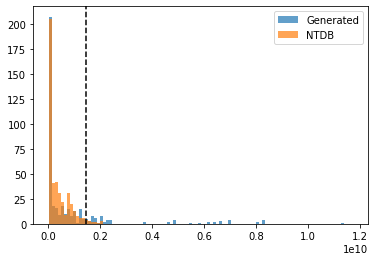

Normal: 336 Anomaly: 113


In [20]:
e9240_report, e9240_border, e9240_model, e9240_trn, e9240_tst, e9240_ood = oc_svm_detector('e9240', e9240_trn_seq, e9240_gen_seq, TRN_FRAC, PRINT_SEQUENCES, pcodes=True)

In [21]:
for s in e9240_trn_seq[:5]:
    print_seq_dsc(s, pcodes=True)
    print()

========= START =========
========== DXS ==========
94222:2nd deg burn chest wall:Blisters, epidermal loss [second degree] of chest wall, excluding breast and nipple
94223:2nd deg burn abdomn wall:Blisters, epidermal loss [second degree] of abdominal wall
94224:2nd deg burn back:Blisters, epidermal loss [second degree] of back [any part]
94325:2nd deg burn shoulder:Blisters, epidermal loss [second degree] of shoulder
94128:2nd deg burn neck:Blisters, epidermal loss [second degree] of neck
94121:2nd deg burn ear:Blisters, epidermal loss [second degree] of ear [any part]
94127:2nd deg burn face NEC:Blisters, epidermal loss [second degree] of forehead and cheek
94810:10-19% bdy brn/3 deg NOS:Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent or unspecified

========= START =========
========== DXS ==========
9492:2nd degree burn NOS:Blisters, epidermal loss [second degree], unspecified site

========= START =========
========== DXS =====

In [22]:
n = e9240_report[e9240_report['score']<e9240_border]

for _,r in n[:5].iterrows():
    print(r['output'])

========= START =========
E924.0:Accident caused by hot substance or object, caustic or corrosive material, and steam, Hot liquids and vapors, including steam
========== DXS ==========
948:Burns classified according to extent of body surface involved:None

========= START =========
E924.0:Accident caused by hot substance or object, caustic or corrosive material, and steam, Hot liquids and vapors, including steam
========== DXS ==========
94810:10-19% bdy brn/3 deg NOS:Burn [any degree] involving 10-19 percent of body surface with third degree burn, less than 10 percent or unspecified
94333:3rd deg burn upper arm:Full-thickness skin loss [third degree, not otherwise specified] of upper arm
94324:2nd deg burn axilla:Blisters, epidermal loss [second degree] of axilla
94128:2nd deg burn neck:Blisters, epidermal loss [second degree] of neck
94125:2nd deg burn nose:Blisters, epidermal loss [second degree] of nose (septum)

========= START =========
E924.0:Accident caused by hot substance or 

In [23]:
w = e9240_report[e9240_report['score']>e9240_border]

for _,r in w[:5].iterrows():
    print(r['output'])

========= START =========
E924.0:Accident caused by hot substance or object, caustic or corrosive material, and steam, Hot liquids and vapors, including steam
========== DXS ==========
94800:Bdy brn < 10%/3d deg NOS:Burn [any degree] involving less than 10 percent of body surface with third degree burn, less than 10 percent or unspecified
94534:3rd deg burn low leg:Full-thickness skin loss [third degree nos] of lower leg
94522:2nd deg burn foot:Blisters, epidermal loss [second degree] of foot
94426:2 deg burn back of hand:Blisters , epidermal loss [second degree] of back of hand
94424:2 deg burn fingr w thumb:Blisters, epidermal loss [second degree] of two or more digits of hand including thumb
94423:2nd deg burn mult finger:Blisters, epidermal loss [second degree] of two or more digits of hand, not including thumb
========== END ==========

========= START =========
E924.0:Accident caused by hot substance or object, caustic or corrosive material, and steam, Hot liquids and vapors, inc